In [1]:
"""
Author Djoffrey
some harmonic pattern scanner functions
(TODO: calculate using (high+low)/2 or etc, not just close price)
(TODO: should return each peak distance)
"""

import pandas as pd
import numpy as np
import talib.abstract as ta
# from scipy.signal import argrelextrema
import mplfinance as mpf

MAIN_FIBB_RATIOS = [0.618, 1.618]
SECOND_FIBB_RATIOS = [0.786, 0.886, 1.13, 1.27]
ALT_FIBB_RATIOS = [0.382, 0.5, 0.707, 1.41, 2.0, 2.24, 2.618, 3.14, 3.618]
AB_CD = [1.27, 1.618, 2.236]

FIBB_RATIOS = [*MAIN_FIBB_RATIOS, *SECOND_FIBB_RATIOS, *ALT_FIBB_RATIOS]

from IPython.core.debugger import set_trace
import os


def kline_to_df(arr) -> pd.DataFrame:
    kline = pd.DataFrame(
        arr,
        columns=['ts', 'open', 'high', 'low', 'close', 'volume' ])
    kline.index = pd.to_datetime(kline.ts, unit='ms')
    kline.drop('ts', axis=1, inplace=True)
    return kline


class HarmonicDetector(object):
    def __init__(self, error_allowed:float=0.05, strict:bool=True, predict_err_rate:float=None):
        self.err = error_allowed
        self.predict_err_rate = self.err if predict_err_rate is None else predict_err_rate

        self.strict = strict

    def is_eq(self, n: float, m: float, err:float=None, l_closed:bool=False, r_closed:bool=True) -> bool:
        _err = self.err if err is None else err
        left = m if l_closed else m * (1 - _err)
        right = m if r_closed else m * (1 + _err)
        return (n >= left) and (n <= right)

    def is_in(self, n: float, l: float, r: float, err:float=None, l_closed:bool=True, r_closed:bool=True) -> bool:
        _err = self.err if err is None else err
        left = l if l_closed else l * (1 - _err)
        right = r if r_closed else r * (1 + _err)
        if self.strict:
            fibb_rates = [
                self.is_eq(n, f_rate) for f_rate in FIBB_RATIOS
                if (f_rate >= left) and (f_rate <= right)
            ]
            return np.any(fibb_rates)
        else:
            return (n >= left) and (n <= right)

    def get_zigzag(self, df: pd.DataFrame, period: int):

        # translated from https://www.tradingview.com/script/mRbjBGdL-Double-Zig-Zag-with-HHLL/

        zigzag_pattern = []
        direction = 0
        changed = False
        for idx in range(1, len(df)):
            highest_high = ta.MAX(df.high[:idx], timeperiod=period)[-1]
            lowest_low = ta.MIN(df.low[:idx], timeperiod=period)[-1]


            new_high = df.high[idx] >= highest_high
            new_low = df.low[idx] <= lowest_low

            if new_high and not new_low:
                if direction != 1:
                    direction = 1
                    changed = True
                elif direction == 1:
                    changed = False
            elif not new_high and new_low:
                if direction != -1:
                    direction = -1
                    changed = True
                elif direction == -1:
                    changed = False

            if new_high or new_low:
                if changed or len(zigzag_pattern)==0:
                    if direction == 1:
                        pat = ['H', df.high[idx], idx]
                        zigzag_pattern.append(pat)
                    elif direction == -1:
                        pat = ['L', df.low[idx], idx]
                        zigzag_pattern.append(pat)
                else:
                    if direction == 1 and df.high[idx] > zigzag_pattern[-1][1]:
                        pat = ['H', df.high[idx], idx]
                        zigzag_pattern[-1] = pat
                    elif direction == -1 and df.low[idx] < zigzag_pattern[-1][1]:
                        pat = ['L', df.low[idx], idx]
                        zigzag_pattern[-1] = pat
                    else:
                        pass
        return zigzag_pattern

    def detect_abcd(self, current_pat: list, predict:bool=False, predict_mode:str='direct'):
        """
        AB=CD is a common pattern in harmonic trading, it is many pattern's inner structure
        AB=CD has two main alternatives 1.27AB=CD and 1.618AB=CD
        """
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'AB': ABC,
                'BC': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(ABC, 0.382, 0.886), # AB
                self.is_in(BCD, 1.13, 1.168), # CD
                self.is_eq(ABCD, 1) # strictly 1/AB = CD
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        elif predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            #XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(ABC, 0.382, 0.886) # AB
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = C - (C - B) * (1 / ABC)
                else:
                    D = C + (B - C) * (1 / ABC)
                BCD = abs(C-D) / abs(B-C)
                #XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 1.13, 2.168)
                ABCD = BCD / (1/ABC)
                ret_dict = {
                    'AB': ABC,
                    'CD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        elif predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            #XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                #self.is_eq(XAB, 0.618), # LEG 1
                self.is_in(ABC, 0.382, 0.886) # AB
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = C - (C - B)*0.786
                else:
                    D = C + (B - C)*0.786
                BCD = abs(C-D) / abs(B-C)
                #XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 1.13, 2.168)
                ABCD = BCD / (1/ABC)
                ret_dict = {
                    'AB': ABC,
                    'CD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None
            else:
                return None

    def detect_gartley(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_eq(XAB, 0.618), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 1.13, 1.168), # LEG 3
                self.is_eq(XAD, 0.786), # LEG 4
                self.is_eq(ABCD, 1) # AB=CD
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        elif predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.618), # LEG 1
                self.is_in(ABC, 0.382, 0.886) # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.786
                else:
                    D = A + (X - A)*0.786
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 1.13, 1.168),
                    self.is_eq(ABCD, 1) # AB=CD
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        elif predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.618), # LEG 1
                self.is_in(ABC, 0.382, 0.886) # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.786
                else:
                    D = A + (X - A)*0.786
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 1.13, 1.168),
                    self.is_eq(ABCD, 1) # AB=CD
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1

                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None
            else:
                return None

    def detect_bat(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(XAB, 0.382, 0.5), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 1.618, 2.168), # LEG 3
                self.is_eq(XAD, 0.886), # LEG 4
                self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.5), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.886
                else:
                    D = A + (X - A)*0.886
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 1.618, 2.168),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.5), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.886
                else:
                    D = A + (X - A)*0.886
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 1.618, 2.168),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
                ]))
                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None
            else:
                return None
    def detect_altbat(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_eq(XAB, 0.382), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 2, 3.168), # LEG 3
                self.is_eq(XAD, 1.13) # LEG 4
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.382), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.13
                else:
                    D = A + (X - A)*1.13
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 2, 3.168)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None

        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.382), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.13
                else:
                    D = A + (X - A)*1.13
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 2, 3.168)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1

                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None

            else:
                return None

    def detect_butterfly(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_eq(XAB, 0.786), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 1.618, 2.24), # LEG 3
                self.is_eq(XAD, 1.27), # LEG 4
                self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.786), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.27
                else:
                    D = A + (X - A)*1.27
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 1.618, 2.24),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.786), # LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.27
                else:
                    D = A + (X - A)*1.27
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 1.618, 2.24)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None

            else:
                return None

    def detect_crab(self, current_pat: list, predict: bool=False,  predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)
            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(XAB, 0.382, 0.618),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 2.618, 3.618), # LEG 3
                self.is_eq(XAD, 1.618), # LEG 4
                self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        elif predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.618),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.618
                else:
                    D = A + (X - A)*1.618
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 2.618, 3.618),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
                ]))


                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        elif predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.618),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.618
                else:
                    D = A + (X - A)*1.618
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 2.618, 3.618),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False

                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None
            else:
                return None
    def detect_deepcrab(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_eq(XAB, 0.886),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
                self.is_in(BCD, 2.24, 3.618), # LEG 3
                self.is_eq(XAD, 1.618), # LEG 4
                self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.886),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.618
                else:
                    D = A + (X - A)*1.618
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 2.24, 3.618),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_eq(XAB, 0.886),# LEG 1
                self.is_in(ABC, 0.382, 0.886), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.618
                else:
                    D = A + (X - A)*1.618
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_in(BCD, 2.24, 3.618),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 2.236), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None

            else:
                return None

    def detect_shark(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(XAB, 0.5, 0.886), # LEG 1
                self.is_in(ABC, 1.13, 1.618), # LEG 2
                self.is_in(BCD, 1.618, 2.24), # LEG 3
                self.is_in(XAD, 0.886, 1.13) # LEG 4
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        elif predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.5, 0.886), # LEG 1
                self.is_in(ABC, 1.13, 1.618), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.886
                else:
                    D = A + (X - A)*0.886
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 1.618, 2.24)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        elif predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.5, 0.886), # LEG 1
                self.is_in(ABC, 1.13, 1.618), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*0.886
                else:
                    D = A + (X - A)*0.886
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                pattern_predict_s2 = self.is_in(BCD, 1.618, 2.24)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1

                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None
            else:
                return None
    def detect_5o(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)

            ABCD = BCD / (1/ABC)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'AB=CD': ABCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(XAB, 1.13, 1.618), # LEG 1
                self.is_in(ABC, 1.618, 2.24), # LEG 2
                self.is_eq(BCD, 0.5), # LEG 3
                #self.is_eq(XAD, 0.5), # LEG 4
                self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 1.13, 1.618), # LEG 1
                self.is_in(ABC, 1.618, 2.24), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.27
                else:
                    D = A + (X - A)*1.27
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_eq(BCD, 0.5),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                if pattern_predict_s2:
                    return [direction, ret_dict]
                else:
                    return None
        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 1.13, 1.618), # LEG 1
                self.is_in(ABC, 1.618, 2.24), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = A - (A - X)*1.27
                else:
                    D = A + (X - A)*1.27
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                ABCD = BCD / (1/ABC)
                pattern_predict_s2 = np.all(np.array([
                    self.is_eq(BCD, 0.5),
                    self.is_eq(ABCD, 1) or self.is_in(ABCD, 0.786, 1.618), # AB=CD and its alternatives
                ]))

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'AB=CD': ABCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s2 and pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None

            else:
                return None
    def detect_cypher(self, current_pat: list, predict: bool=False, predict_mode:str='direct'):
        # current_pat: [['H', new_high, idx],...]
        # Legs
        if not predict:
            X, A, B, C, D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            BCD = abs(C-D) / abs(B-C)
            XCD = abs(D-C) / abs(X-C)

            ret_dict = {
                'XAB': XAB,
                'XAD': XAD,
                'ABC': ABC,
                'BCD': BCD,
                'XCD': XCD
            }

            # Detect
            pattern_found = np.all(np.array([
                self.is_in(XAB, 0.382, 0.786), # LEG 1
                self.is_in(ABC, 1.272, 1.414), # LEG 2
                #self.is_in(BCD, 1.618, 2.24), # LEG 3
                self.is_eq(XCD, 0.786) or self.is_eq(XAD, 0.786) ,  # LEG 4
            ]))
            direction = 1 if D<C else -1
            if pattern_found:
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='reverse':
            _, X, A, B, C = [pat[1] for pat in current_pat]
            last_direction = current_pat[-1][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)
            #XCD = abs(D-C) / abs(X-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.786), # LEG 1
                self.is_in(ABC, 1.272, 1.414), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = C - (C - X)*0.786
                else:
                    D = C + (X - C)*0.786
                XCD = abs(D-C) / abs(X-C)
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                # pattern_predict_s2 = self.is_eq(BCD, 0.786)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'XCD': XCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                return [direction, ret_dict]
            else:
                return None
        if predict_mode=='direct':
            X, A, B, C, origin_D = [pat[1] for pat in current_pat]
            last_direction = current_pat[-2][0]
            XAB = abs(B-A) / abs(X-A)
            #XAD = abs(A-D) / abs(X-A)
            ABC = abs(B-C) / abs(A-B)
            #BCD = abs(C-D) / abs(B-C)
            #XCD = abs(D-C) / abs(X-C)

            # Detect
            pattern_predict_s1 = np.all(np.array([
                self.is_in(XAB, 0.382, 0.786), # LEG 1
                self.is_in(ABC, 1.272, 1.414), # LEG 2
            ]))
            if pattern_predict_s1:
                if last_direction == 'H':
                    # XAD
                    D = C - (C - X)*0.786
                else:
                    D = C + (X - C)*0.786
                XCD = abs(D-C) / abs(X-C)
                BCD = abs(C-D) / abs(B-C)
                XAD = abs(A-D) / abs(X-A)
                # pattern_predict_s2 = self.is_eq(BCD, 0.786)

                ret_dict = {
                    'XAB': XAB,
                    'XAD': XAD,
                    'ABC': ABC,
                    'BCD': BCD,
                    'XCD': XCD,
                    'predict_D': D
                }
                direction = 1 if D<C else -1
                pattern_predict_s3 = False
                if (direction == 1 and D < origin_D) or \
                   (direction == -1 and D > origin_D):
                    pattern_predict_s3 = True

                if pattern_predict_s3:
                    return [direction, ret_dict]
                else:
                    return None

            else:
                return None

    def detect_pattern(self, zigzag_pattern):
        res = []
        # price default to close
        for idx in range(0, len(zigzag_pattern) - 5 + 1):
            current_pat = [pat for pat in zigzag_pattern[idx:idx+5]]
            current_idx = [pat[2] for pat in zigzag_pattern[idx:idx+5]]
            detect_funcions = [
                (self.detect_gartley, 'gartley'),
                (self.detect_bat, 'bat'),
                (self.detect_altbat, 'altbat'),
                (self.detect_butterfly, 'butterfly'),
                (self.detect_crab, 'crab'),
                (self.detect_deepcrab, 'deepcrab'),
                (self.detect_shark, 'shark'),
                (self.detect_5o, '5o'),
                (self.detect_cypher, 'cypher'),
                (self.detect_abcd, 'abcd'),
            ]
            if len(current_pat) == 5:
                for func, func_name in detect_funcions:
                    r = func(current_pat)
                    if r is not None:
                        direction, ret_dict = r
                        bull_or_bear = 'bullish' if direction==1 else 'bearish'
                        label = f'{bull_or_bear} {func_name}'
                        res.append([current_pat, current_idx, label, ret_dict])
        return res

    def predict_pattern(self, zigzag_pattern):
        res = []
        # predict reverse pattern
        current_pat = zigzag_pattern[-5:]
        current_idx = [pat[2] for pat in zigzag_pattern[-5:]]

        detect_funcions = [
            (self.detect_gartley, 'gartley'),
            (self.detect_bat, 'bat'),
            (self.detect_altbat, 'altbat'),
            (self.detect_butterfly, 'butterfly'),
            (self.detect_crab, 'crab'),
            (self.detect_deepcrab, 'deepcrab'),
            (self.detect_shark, 'shark'),
            (self.detect_5o, '5o'),
            (self.detect_cypher, 'cypher'),
        ]
        if len(current_pat) == 5:
            for func, func_name in detect_funcions:
                r = func(current_pat, predict=True, predict_mode='reverse')
                if r is not None:
                    direction, ret_dict = r
                    _, X, A, B, C = [pat[1] for pat in current_pat]
                    D = ret_dict['predict_D']
                    bull_or_bear = 'bullish' if direction==1 else 'bearish'
                    label = f'{bull_or_bear} {func_name} predict next D: {D}'
                    # Funny ha? but shit happens
                    if D > 0:
                        p_pattern = [X, A, B, C, D]
                        p_idx = [*current_idx[1:], -1]
                        res.append([p_pattern, p_idx, label, ret_dict])

            for func, func_name in detect_funcions:
                r = func(current_pat, predict=True, predict_mode='direct')
                if r is not None:
                    direction, ret_dict = r
                    X, A, B, C, origin_D = [pat[1] for pat in current_pat]
                    D = ret_dict['predict_D']
                    bull_or_bear = 'bullish' if direction==1 else 'bearish'
                    label = f'{bull_or_bear} {func_name} predict current D: {D}'
                    # Funny ha? but shit happens
                    if D > 0:
                        p_pattern = [X, A, B, C, D]
                        res.append([p_pattern, current_idx, label, ret_dict])
        return res

    def get_patterns(self, df: pd.DataFrame, window: int, predict: bool=False, plot:bool=False):
        zigzag_pattern = self.get_zigzag(df, window)
        patterns = self.detect_pattern(zigzag_pattern)
        if plot:
            points = [(df.index[k[2]], k[1]) for k in zigzag_pattern]
            patterns_line = [list(zip(
                [df.index[dt_idx] for dt_idx in pat[1]],
                [val_idx[1] for val_idx in pat[0]]
            )) for pat in patterns]
            mpf.plot(df,type='candle', alines=dict(alines=patterns_line, colors=['b','r','c','k','g']))
        if predict:
            predict_res = self.predict_pattern(zigzag_pattern)
            return patterns, predict_res
        return patterns, None

    def filter_duplicats(self, patterns, predict:bool=False):
        pat_set = set()
        ret = []
        if not predict:
            for pat in patterns:
                X,A,B,C,D = pat[1]
                pat_str = f'{X}-{A}-{B}-{C}-{D}'
                if pat_str not in pat_set:
                    ret.append(pat)
                    pat_set.add(pat_str)
        else:
            # predict
            for pat in patterns:
                X,A,B,C,D = pat[1] # get index
                label = pat[2] # get_label
                #predict_D = pat[3]['predict_D'] # get_predict_D
                pat_str = f'{X}-{A}-{B}-{C}-{D}-{label}'
                if pat_str not in pat_set:
                    ret.append(pat)
                    pat_set.add(pat_str)
        return ret

    def plot_patterns(self, df, patterns, predict_patterns, plot_predict:bool=True, save_fig:bool=False, file_name:str=None, file_data_path='./data/'):
        """
        plot results, if save_fig, will save_fig to {file_name}
        """
        # points = [(df.index[k[2]], k[1]) for k in zigzag_pattern]
        patterns_line = [list(zip(
            [df.index[dt_idx] for dt_idx in pat[1]],
            [val_idx[1] for val_idx in pat[0]]
        )) for pat in patterns if pat[2][-4:]!='abcd']
        if plot_predict:
            new_index = df.index.append(pd.Index([
                df.index[-1] + 10*(df.index[-1] - df.index[-2])
            ]))
            df = pd.DataFrame(df, index=new_index)
            df.fillna(0)
            patterns_predict_line = [list(zip(
                [df.index[dt_idx] for dt_idx in pat[1]],
                [val_idx for val_idx in pat[0]]
            )) for pat in predict_patterns if pat[2][-4:]!='abcd']

            predict_Ds = [pat[3]['predict_D'] for pat in predict_patterns]
            patterns_line.extend(patterns_predict_line)
        else:
            predict_Ds = []

        mc = mpf.make_marketcolors(base_mpf_style='yahoo')
        # Create a style based on `seaborn` using those market colors:
        style  = mpf.make_mpf_style(base_mpl_style='seaborn', marketcolors=mc)

        if len(patterns_line) > 0:
            if save_fig and file_name is not None:
                if not os.path.exists(file_data_path):
                    os.mkdir(file_data_path)
                file_path = file_data_path + file_name
                mpf.plot(df,
                         type='candle',
                         mav=(10,21,55,120),
                         style=style,
                         alines=dict(alines=patterns_line,
                                     colors=['b','r','c','k','g'],
                                     linewidths=3,
                                     alpha=0.5
                                     ),
                         hlines=dict(hlines=predict_Ds, colors=['g'],linestyle='-.'),
                         savefig=file_path
                     )
            else:
                mpf.plot(df,
                         type='candle',
                         mav=(10,21,55,120),
                         style=style,
                         alines=dict(alines=patterns_line,
                                     colors=['b','r','c','k','g'],
                                     linewidths=3,
                                     alpha=0.5
                                     ),
                         hlines=dict(hlines=predict_Ds, colors=['g'],linestyle='-.'),
                         #savefig='test.svg'
                         )

    def search_patterns(self, df: pd.DataFrame, predict: bool=False, only_last:bool=False, last_n:int=0, plot:bool=False, plot_predict:bool=True, return_dt_idx=True, save_fig_name:str=None):
        assert last_n < 5
        all_patterns = list()
        all_predict_patterns = list()
        for window in [8, 13, 21, 34, 55]:
            zigzag_pattern = self.get_zigzag(df, window)
            #print(zigzag_pattern)
            if predict:
                ori_err = self.err
                self.err = self.predict_err_rate
                predict_res = self.predict_pattern(zigzag_pattern)
                all_predict_patterns.extend(predict_res)
                self.err = ori_err
            patterns = self.detect_pattern(zigzag_pattern)
            if only_last:
                all_patterns.extend(patterns[-1:])
            else:
                all_patterns.extend(patterns)

        if only_last and last_n>0:
            all_patterns = [pat for pat in all_patterns if pat[0][-1][2] == len(df) - last_n]

        all_patterns = self.filter_duplicats(all_patterns)
        all_predict_patterns = self.filter_duplicats(all_predict_patterns, predict=True)
        if plot:
            if save_fig_name is not None:
                self.plot_patterns(df, all_patterns, all_predict_patterns, save_fig=True, file_name=save_fig_name)
            else:
                self.plot_patterns(df, all_patterns, all_predict_patterns, save_fig=False)

        if return_dt_idx:
            all_patterns = [
                [pat[0],
                 [df.index[dt_idx] for dt_idx in pat[1]],
                 pat[2],
                 pat[3]]
                for pat in all_patterns]
            all_predict_patterns = [
                [pat[0],
                 [df.index[dt_idx] for dt_idx in pat[1]],
                 pat[2],
                 pat[3]]
                for pat in all_predict_patterns]

        return all_patterns, all_predict_patterns

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
import glob


interval=600

if interval < 3000 :
    slice = round(interval/120)
#if environment.INTERVAL > 1650 and environment.INTERVAL < 3000  :
#    slice = round(environment.INTERVAL/240)
if interval > 3000 :
    slice = round(interval/240)
df =yf.download(tickers='BTC-JPY', period = '1000h', interval = '2m')
df = df.rename(columns={'High': 'high', 'Low': 'low', 'Open': 'open', 'Close': 'close', 'Volume': 'volume'})    
df=df[::slice]
df=df.tail(302)
print("The sliced number for time period is ", slice)

[*********************100%***********************]  1 of 1 completed
The sliced number for time period is  5


In [4]:

#df = pd.read_excel('data/src/sample.xlsx', index_col=0)

df
df.drop('Adj Close', axis=1, inplace=True)
df

,open,high,low,close,volume
Datetime,,,,,
2023-06-22 01:30:00+00:00,4280434.0,4280434.0,4275326.5,4275326.5,145227776
2023-06-22 01:40:00+00:00,4275979.0,4275979.0,4275818.5,4275818.5,2604138496
2023-06-22 01:50:00+00:00,4272098.0,4274003.5,4272098.0,4274003.5,591396864
2023-06-22 02:00:00+00:00,4273423.0,4273856.5,4273423.0,4273856.5,51904512
2023-06-22 02:10:00+00:00,4266444.5,4266807.0,4266444.5,4266807.0,0
...,...,...,...,...,...
2023-06-24 03:02:00+00:00,4420488.0,4420488.0,4417219.0,4417219.0,488898560
2023-06-24 03:12:00+00:00,4419129.0,4419129.0,4418405.5,4418405.5,0
2023-06-24 03:22:00+00:00,4420217.5,4422282.0,4420217.5,4422282.0,606076928


In [5]:

#from HarmonicPatterns.harmonic_functions import HarmonicDetector
#from HarmonicPatterns.harmonic import send_alert, search_function
from functools import partial
import time

detector = HarmonicDetector(error_allowed=0.07, strict=True, predict_err_rate=0.07)
#search = partial(search_patterns, detector, ccxt_args=ccxt_options, only_last=False)

In [6]:
#!pip3 install HarmonicPatterns

In [6]:
a=HarmonicDetector(df)
a

In [8]:
#detector()

TypeError: 'HarmonicDetector' object is not callable

In [7]:
def get_frame_fname(level=0):
    return sys._getframe(level+1).f_code.co_name

def send_alert(title: str, body: str):
    """
    用Redis缓存一下，主要是为了不重复发送
    """
    body = body.replace('\n', '\n\n')
    template='''
    \n\n
    {body}
    \n\n
    '''
    if not redis_client.exists(body):
        r = httpx.post(NOTIFY_URL, data={'text': title, 'desp': template.format(body=body)})
        redis_client.setex(body, 60 * 60 * 30, 1)
        return r.status_code
    else:
        return None


def kline_to_df(arr) -> pd.DataFrame:
    kline = pd.DataFrame(
        arr,
        columns=['ts', 'open', 'high', 'low', 'close', 'volume' ])
    kline.index = pd.to_datetime(kline.ts, unit='ms')
    kline.drop('ts', axis=1, inplace=True)
    return kline


def search_function(detector, exchange_id, symbols, periods=interval, ccxt_args={}, savefig=False, predict=True, only_last=False, alert=False, plot=False):
    client = getattr(ccxt, exchange_id)(ccxt_args)
    client.load_markets()
    RETRY_TIMES=3
    for symbol in symbols:
        for period in periods:
            logger.info(f'------------------calculating {symbol} {period}------------------')
            retry = RETRY_TIMES
            while retry>0:
                try:
                    df = kline_to_df(client.fetch_ohlcv(symbol, period, limit=1000))

                    patterns, predict_patterns = detector.search_patterns(df, only_last=only_last, last_n=4, plot=plot, predict=predict)
                    break
                except Exception as e:
                    logger.error(e)
                    retry -= 1
                    if retry==0: raise
                    continue
            for pat in patterns:
                msg = f'{symbol} {period} \npatterns found: {pat[1]}, {pat[0]}, \n {pat[2]}, {pat[3]}'
                logger.info(msg)
                if alert and pat[0][-1][2] == len(df)-1:
                    send_alert(f'Pattern_Found_{symbol}_{period}', msg)

            for pat in predict_patterns:
                msg = '\n'.join([f'{p} {v}' for p,v in list(zip([str(dt) for dt in pat[1]], [p for p in pat[0]]))])
                msg = f'{symbol} {period} {msg} {pat[2]} {pat[3]}'
                logger.info(msg)
                if alert:
                    send_alert(f'Pattern_Predict_{symbol}_{period}', msg)




In [8]:

#from HarmonicPatterns.harmonic_functions import HarmonicDetector
#from HarmonicPatterns.harmonic import send_alert, search_function
from functools import partial
import time

detector = HarmonicDetector(error_allowed=0.07, strict=True, predict_err_rate=0.07)
search = partial(search_function, detector, ccxt_args=None, only_last=False)

In [14]:
#search_pattern(df)

NameError: name 'search_pattern' is not defined

In [15]:
#HarmonicDetector(df)
#    def search_patterns(self, df: pd.DataFrame, predict: bool=False, only_last:bool=False, last_n:int=0, plot:bool=False, plot_predict:bool=True, return_dt_idx=True, save_fig_name:str=None):


# HarmonicDetector.get_zigzag( df, '10')

In [16]:
#a=HarmonicDetector()
#a.get_zigzag(df=df, period=10)
#a.search_patterns(df)

([], [])

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
import glob


interval=600

if interval < 3000 :
    slice = round(interval/120)
#if environment.INTERVAL > 1650 and environment.INTERVAL < 3000  :
#    slice = round(environment.INTERVAL/240)
if interval > 3000 :
    slice = round(interval/240)
df =yf.download(tickers='BTC-JPY', period = '10d', interval = '5m')
df = df.rename(columns={'High': 'high', 'Low': 'low', 'Open': 'open', 'Close': 'close', 'Volume': 'volume'})    
df=df[::slice]
df=df.tail(700)
print("The sliced number for time period is ", slice)

#df2=different interval
df2 =yf.download(tickers='BTC-JPY', period = '10d', interval = '15m')
df2 = df.rename(columns={'High': 'high', 'Low': 'low', 'Open': 'open', 'Close': 'close', 'Volume': 'volume'})    
df2=df[::slice]
df2=df.tail(70)

df3 =yf.download(tickers='BTC-JPY', period = '10d', interval = '30m')
df3 = df.rename(columns={'High': 'high', 'Low': 'low', 'Open': 'open', 'Close': 'close', 'Volume': 'volume'})    
df3=df[::slice]
df3=df.tail(70)

print(df)

#search('binance', s, periods = ['15m', '30m', '1h', '4h'])

[*********************100%***********************]  1 of 1 completed
The sliced number for time period is  5
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                 open        high         low       close  \
Datetime                                                                    
2023-06-16 00:00:00+00:00  3587509.50  3587509.50  3574350.50  3574350.50   
2023-06-16 00:25:00+00:00  3565190.50  3568199.25  3565190.50  3568199.25   
2023-06-16 00:50:00+00:00  3574837.25  3574837.25  3571675.00  3572679.00   
2023-06-16 01:15:00+00:00  3564677.75  3565758.75  3564677.75  3565030.75   
2023-06-16 01:40:00+00:00  3569662.50  3571391.50  3568937.25  3571391.50   
...                               ...         ...         ...         ...   
2023-06-25 08:35:00+00:00  4417935.50  4418915.00  4417869.50  4418807.00   
2023-06-25 09:00:00+00:00  4418725.00  4418725.00  4415393.5

In [9]:
a=HarmonicDetector(error_allowed=0.2, strict=True, predict_err_rate=0.2)
#a.get_zigzag(df=df, period=10)
aa=a.search_patterns(df, False,False,0,False,False,True,None )

try:
    if aa[0][0][1] is not None:
        print("Gartley pattern present at ...")
        print(aa[0][0][1])
        if "bearish" in aa[0][0][2]:
            print("its a bearish", aa[0][0][2])
        if "bullish" in aa[0][0][2]:
            print("its a bullish", aa[0][0][2])
            
except :
    print("no gartley pattern")
    pass


SyntaxError: 'return' outside function (1822386836.py, line 13)

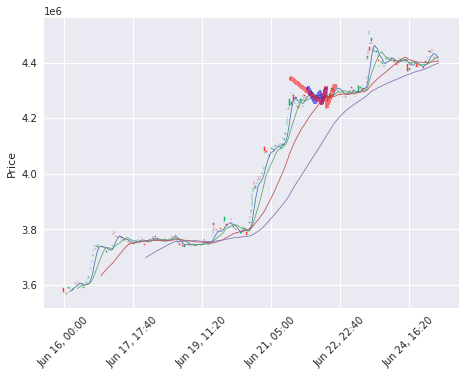

([[[['H', 4312706.0, 353],
    ['L', 4257629.5, 364],
    ['H', 4293290.5, 371],
    ['L', 4255152.5, 374],
    ['H', 4310431.0, 380]],
   [Timestamp('2023-06-22 03:05:00+0000', tz='UTC'),
    Timestamp('2023-06-22 07:40:00+0000', tz='UTC'),
    Timestamp('2023-06-22 10:35:00+0000', tz='UTC'),
    Timestamp('2023-06-22 11:50:00+0000', tz='UTC'),
    Timestamp('2023-06-22 14:20:00+0000', tz='UTC')],
   'bearish shark',
   {'XAB': 0.6474812306519114,
    'XAD': 0.9586938167821122,
    'ABC': 1.0694596337735902,
    'BCD': 1.4494336357438775}],
  [[['H', 4513773.5, 442],
    ['L', 4383383.5, 457],
    ['H', 4422294.0, 469],
    ['L', 4393517.5, 482],
    ['H', 4425139.5, 491]],
   [Timestamp('2023-06-23 16:10:00+0000', tz='UTC'),
    Timestamp('2023-06-23 22:25:00+0000', tz='UTC'),
    Timestamp('2023-06-24 03:25:00+0000', tz='UTC'),
    Timestamp('2023-06-24 08:50:00+0000', tz='UTC'),
    Timestamp('2023-06-24 12:35:00+0000', tz='UTC')],
   'bearish abcd',
   {'AB': 0.7395561609334241,
 

In [5]:
a.search_patterns(df, False,False,0,True,True,True,None )


In [6]:
a.search_patterns(df2, False,False,0,True,True,True,None )

([], [])

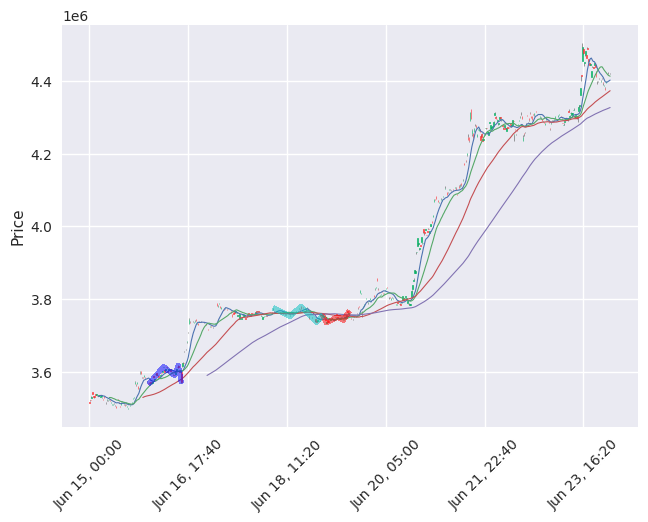

([[[['L', 3565865.0, 60],
    ['H', 3613738.75, 75],
    ['L', 3589572.75, 86],
    ['H', 3617185.0, 90],
    ['L', 3568295.5, 93]],
   [Timestamp('2023-06-16 01:00:00+0000', tz='UTC'),
    Timestamp('2023-06-16 07:15:00+0000', tz='UTC'),
    Timestamp('2023-06-16 11:50:00+0000', tz='UTC'),
    Timestamp('2023-06-16 13:30:00+0000', tz='UTC'),
    Timestamp('2023-06-16 14:45:00+0000', tz='UTC')],
   'bullish shark',
   {'XAB': 0.5047860257447975,
    'XAD': 0.949231050419071,
    'ABC': 1.1426073822726144,
    'BCD': 1.7705728435748627}],
  [[['H', 3755689.0, 236],
    ['L', 3734371.5, 240],
    ['H', 3750567.0, 251],
    ['L', 3741424.25, 257],
    ['H', 3766914.25, 263]],
   [Timestamp('2023-06-19 02:20:00+0000', tz='UTC'),
    Timestamp('2023-06-19 04:00:00+0000', tz='UTC'),
    Timestamp('2023-06-19 08:35:00+0000', tz='UTC'),
    Timestamp('2023-06-19 11:05:00+0000', tz='UTC'),
    Timestamp('2023-06-19 13:35:00+0000', tz='UTC')],
   'bearish deepcrab',
   {'XAB': 0.7597279230679019

In [20]:
a.search_patterns(df3, False,False,0,True,True,True,None )